In [1]:
%matplotlib inline

import numpy
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import descartes
import shapely.geometry, shapely.ops

import pymaxion
pymaxion.__version__

def plot_polygon(polygon, **kwargs):
    axes = plt.gca()
    if polygon.type.startswith('Multi'):
        for poly in polygon:
            axes.add_patch(descartes.PolygonPatch(poly, **kwargs))
    else:
        axes.add_patch(descartes.PolygonPatch(polygon, **kwargs))

def plot_linestring(linestring, **kwargs):
    axes = plt.gca()
    if linestring.type.startswith('Multi'):
        for l in linestring:
            axes.plot(*l.xy, **kwargs)
    else:
        axes.plot(*linestring.xy, **kwargs)

In [2]:
# Load up shapes
land = pymaxion.utilities.get_land()
area_idx = numpy.argsort([l.area for l in land])
shapes = shapely.geometry.MultiPolygon([land[int(i)] for i in area_idx[-1:-7:-1]
                                        if i != 3])
shape = shapes[0]

# Load up projection
proj = pymaxion.DymaxionProjection()
face_idxs = (0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19)
problems = (8, 13)
# face_idxs = range(20)

# Load up graticules
bbox = (0, -90, 180, 90)
graticules = pymaxion.utilities.make_grid(bbox=bbox, npoints=200, graticule_spacing=20)

In [3]:
from pymaxion.conversions import *

# Define rotation functions
def rotate_to_face(face_idx):
    rot_matrix = proj.face_rotation_matrices[face_idx]
    def _transform_fn(theta, phi):
        return cartesian_to_spherical(
            *numpy.dot(rot_matrix, 
                       numpy.vstack(spherical_to_cartesian(theta, phi))))
    return _transform_fn

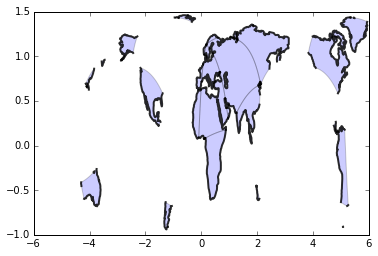

In [4]:
for _shape in shapes:
    for face_idx in face_idxs:
        shape = proj.get_intersection(_shape, face_idx)
        if shape.is_empty:
            continue
        boundary = proj.get_intersection(_shape.boundary, face_idx)
        shape = pymaxion.operations.fix_longitude(
            shapely.ops.transform(longlat_to_spherical, shape),
            max_distance=numpy.pi)
        boundary = pymaxion.operations.fix_longitude(
            shapely.ops.transform(longlat_to_spherical, boundary),
            max_distance=numpy.pi)
        plot_polygon(shape, alpha=0.2)
        plot_linestring(boundary, color='black', alpha=0.8, linewidth=2)

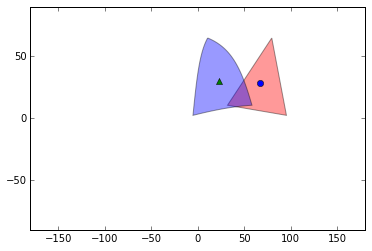

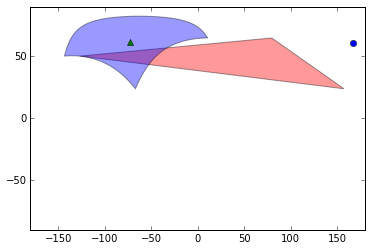

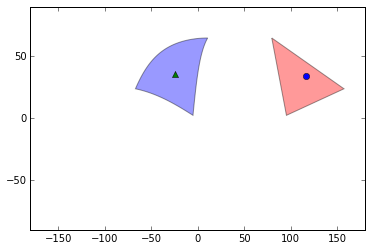

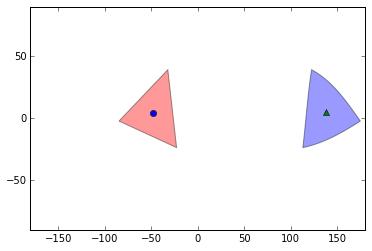

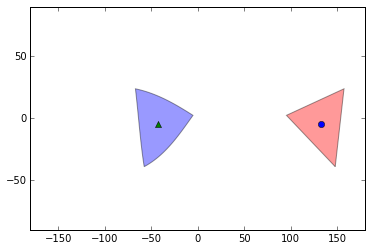

In [5]:
from pymaxion.operations import fix_longitude
for idx in (0, 3, 4, 8, 13):
    plt.figure()
    centre = spherical_to_longlat(
        *cartesian_to_spherical(*proj.face_centres[idx]))

    proj = pymaxion.DymaxionProjection()
    vidx = proj.faces[idx]
    vertices = [spherical_to_longlat(*cartesian_to_spherical(*v))
                            for v in proj.vertices[vidx]]
    vertex_list = numpy.vstack([vertices[0], vertices[1], 
                                vertices[2], vertices[0]])
    face = shapely.geometry.Polygon(vertex_list)
    poly = proj.latlong_faces[idx]

    plot_polygon(face, facecolor='red', alpha=0.4)
    plot_polygon(poly, facecolor='blue', alpha=0.4)

    # shape = [proj.get_intersection(shapes[i], idx) for i in (0, 1)]
    plt.plot(*centre, marker='o', linewidth=0)
    plt.plot(*poly.centroid.xy, marker='^', linewidth=0)
    plt.xlim(-180, 180)
    plt.ylim(-90, 90)

In [32]:
def pipeline(*transforms):
    """ Generate a Shapely transformation pipeline
    """
    def _transform_fn(shape):
        for transform in transforms:
            try:
                shape = shapely.ops.transform(transform, shape)
            except TypeError:
                shape = transform(shape)
        return shape
    return _transform_fn

for face_idx in range(19):
    transform = pipeline(
        lambda s: proj.get_intersection(s, face_idx),
        pymaxion.conversions.longlat_to_spherical,
        rotate_to_face(face_idx))

    subshape = transform(shape)
    subboundary = transform(shape.boundary)
    subgraticules = transform(graticules)
    t2 = pipeline(pymaxion.conversions.longlat_to_spherical,
                  rotate_to_face(face_idx))
    print('Face {0} centre point:'.format(face_idx), 
          t2(shapely.geometry.Point(cartesian_to_spherical(*proj.face_centres[face_idx]))))
    if subshape.is_empty:
        continue
    
    plt.figure()
    axes = plt.gca() 
    plot_polygon(subshape, facecolor='white', edgecolor='none', zorder=1)
    plot_linestring(subboundary, color='black', linewidth=2, alpha=0.8, zorder=2)
    plot_linestring(subgraticules, color='gray', linewidth=1, dashes=(4, 2), alpha=0.7, zorder=0)
    axes.set_aspect('equal')
    axes.set_title('Face {0}'.format(face_idx))

AttributeError: 'list' object has no attribute 'is_empty'

(-1, 1)

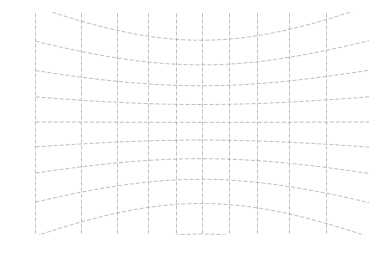

In [21]:
axes = plt.gca()
graticule_fmt = dict(color='gray', dashes=(4, 2), alpha=0.5)
axes.add_patch(descartes.PolygonPatch(shape))
for grat in graticules:
    grat = shapely.ops.transform(gnomonic, grat)
    axes.plot(*grat.xy, **graticule_fmt)
axes.set_axis_off()
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

In [ ]:
# formats

lfmt = dict(color='gray', linewidth=2)
ffmt = dict(color='red', linewidth=2)
cfmt = dict(color='red', marker='o', markeredgecolor='none', linewidth=0)
face_fmt = dict(facecolor='none', edgecolor='gray', alpha=0.8, linewidth=2, zorder=4)

def plot_face(face_idx):
    rotate = lambda pts: \
        cartesian_to_spherical(*numpy.dot(proj.face_rotation_matrices[face_idx], pts))

    fig = plt.figure(figsize=(11,21))
    axes = fig.gca()
    axes.set_aspect('equal')

    # Plot face location
    face_poly = rotate(proj.latlong_faces[face_idx])
    face_centre = rotate(face_centre)
    axes.add_patch(descartes.PolygonPatch(face_poly, **face_fmt))

    # Make plots
    for geom in graticules:
        # Transform and cut out points that are not neccesary
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)

        # Generate gnomonic projection of points
        mask = is_inside_bbox(hemisphere, points)
        if any(mask):
            try:
                line = shapely.geometry.LineString(
                    numpy.asarray(gnomonic(*points[:, mask])).transpose()
                ).intersection(face_poly)
                if line.type.startswith('Multi'):
                    for l in line:
                        ax2.plot(*l.xy, **gfmt)
                else:
                    ax2.plot(*line.xy, **gfmt)
            except:
                pass

    for geom in shapes.boundary:
        # Transform and cut out points that are not neccesary
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)

        # Generate gnomonic projection of points
        mask = is_inside_bbox(hemisphere, points)
        if any(mask):
            try:
                boundary = shapely.geometry.LineString(
                    numpy.asarray(gnomonic(*points[:, mask])).transpose())
                if len(boundary) < 4:
                    continue
                poly = shapely.geometry.Polygon(boundary)
                ax2.add_patch(descartes.PolygonPatch(
                    poly, facecolor='white', edgecolor='none', zorder=3))
                boundary = boundary.intersection(face_poly)
                if boundary.type.startswith('Multi'):
                    for b in boundary:
                        ax2.plot(*b.xy, color='black', linewidth=2, zorder=10)
                else:
                    ax2.plot(*boundary.xy, color='black', linewidth=2, zorder=10)
            except:
                pass

    # Mask out everything outside the triangle
    xbounds, ybounds = ax2.get_xlim(), ax2.get_ylim()
    mask = shapely.geometry.box(xbounds[0], ybounds[0], xbounds[1], ybounds[1]).difference(face_poly)
#     ax2.add_patch(descartes.PolygonPatch(
#             mask, facecolor='white', edgecolor='none',
#             linewidth=0, zorder=10))
    ax2.set_axis_off()

In [ ]:
boundary = shapely.geometry.MultiLineString([numpy.radians(c.coords) for c in land[101].boundary])
print([b.is_valid for b in boundary])
boundary

In [ ]:
for face_idx in range(20):
    transform = lambda pts: \
        cartesian_to_spherical(*numpy.dot(
                proj.face_rotation_matrices[face_idx], pts))        

    face_points = proj.vertices[proj.faces[face_idx]]
    face_points = numpy.vstack([face_points, face_points[0]]).transpose()
    face_points = transform(face_points)
    face_centre = proj.face_centres[face_idx]
    face_centre = transform(face_centre)
    face_poly = shapely.geometry.Polygon(numpy.asarray(gnomonic(*face_points)).transpose())

    for geom in shapes.boundary:
        # Transform and cut out points that are not neccesary
        points = numpy.radians(geom.coords).transpose()
        points = spherical_to_cartesian(*points)
        points = transform(points)        
        intsec = boundary.intersection(face_poly)
        if not intsec.is_empty:
            plt.figure()
            plt.plot(*face_poly.boundary.xy)
            plt.plot(*intsec.boundary.xy)
    

In [ ]:
for idx in range(len(proj.faces)):
    plot_face(idx)